In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Response Matching

## Load survey data

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel(path, sheet_name="Survey_32W", converters={'T3':str})

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]') &
    (survey_32W['T3'] != 'no comments') &
    (survey_32W['T3'] != 'no comments.') &
    (survey_32W['T3'] != '0') &
    (survey_32W['T3'] != 'none.') &
    (survey_32W['T3'] != '[none]') &
    (survey_32W['T3'] != 'no comment') &
    (survey_32W['T3'] != 'No comments were made') &
    (survey_32W['T3'] != 'No Reason') &
    (survey_32W['T3'] != 'No reason.')]

# Select responses
res_same_32W = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate_32W = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()
res_32W = res_same_32W + res_separate_32W

## Get embeddings

In [3]:
embed_same_32W = model.encode(res_same_32W)
embed_separate_32W = model.encode(res_separate_32W)
embed_32W = np.concatenate((embed_same_32W, embed_separate_32W), axis = 0)

## Compare responses

In [4]:
def compare_all(i, res, embed):
    distances = scipy.spatial.distance.cdist([embed], embed_32W, "cosine")[0]
    distances_sorted = sorted(zip(range(len(distances)), distances), key=lambda x: x[1])
    return {
        "index": i,
        "response": res,
        "choice": "same" if i < len(res_same_32W) else "separate",
        "match": res_32W[distances_sorted[1][0]],
        "match_choice": "same" if distances_sorted[1][0] < len(res_same_32W) else "separate",
        "score": 1-distances_sorted[1][1]
    }

results = [compare_all(i, res, embed) for i, res, embed in zip(range(len(res_32W)), res_32W, embed_32W)]

## Write as CSV

In [5]:
# Convert list of results to dataframe
df = pd.DataFrame(results)
# Sort results by cosine similarity
df = df.sort_values('score', ascending=False)
# Write to csv
df.to_csv("../data/response_match.csv", index=False)

# Cluster responses

In [6]:
k = 20
kmeans = KMeans(n_clusters=k).fit(embed_32W)

# Print results
for i in range(k):
    print("Cluster", i)
    print([results[j]['response'] for j in range(len(kmeans.labels_)) if kmeans.labels_[j] == i])

Cluster 0
["It's [unclear]one car, who[/unclear] should not make any difference, any good soldier could easily overlook that", 'If separated each group would try to be better but this would cause jealousy and indifference.', 'I realize, however, that my answers to the last few questions are impractical because of the hostile attitude southern whites & some northern whites take toward living with negroes. But if Chinese or Filipinos are accepted into the same ranks as the whites, why not the negro.', 'Lessens infiror and superior complexes among the men of what is supposed to be a united people', "Because myself would soldier with them, don't think any more white would like", 'Their living conditions have been different in civilian life, so I feel they would be just as uncomfortable as white race.', 'They would feel more natural among themselves just as the different national combat groups serving in England feel at [unclear]eme[/unclear] with people of their own. ', 'white boys [unclea

# Low-rank approximation?

## Plot singular values

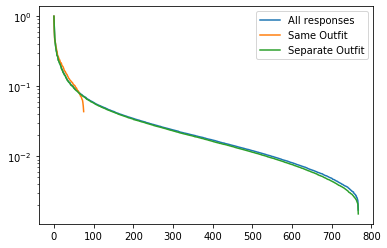

In [7]:
# Transpose so each column is an embedding
for A in [np.transpose(embed_32W), np.transpose(embed_same_32W), np.transpose(embed_separate_32W)]:
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    S = [S[i]/S[0] for i in range(len(S))]
    plt.semilogy(S)
plt.legend(["All responses", "Same Outfit", "Separate Outfit"])

## Heatmap of matrix entries

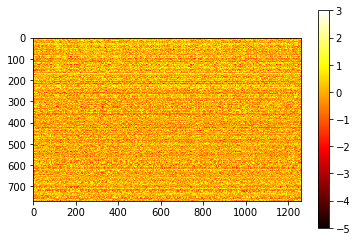

In [8]:
plt.imshow(np.transpose(embed_32W), cmap='hot', interpolation='nearest', vmin=-5, vmax=3)
plt.colorbar()
plt.show()

## Repeat, only using responses with high cosine similarity scores

In [9]:
# Select top results and their embeddings
def select_results(thresh):
    results_best = [results[i] for i in range(len(results)) if results[i]['score'] > thresh]
    embed_32W_best = [embed_32W[results_best[i]['index']] for i in range(len(results_best))]
    embed_same_32W_best = [embed_32W[results_best[i]['index']] for i in range(len(results_best))
                           if results_best[i]['choice'] == "same"]
    embed_separate_32W_best = [embed_32W[results_best[i]['index']] for i in range(len(results_best))
                           if results_best[i]['choice'] == "separate"]
    return(embed_32W_best, embed_same_32W_best, embed_separate_32W_best)

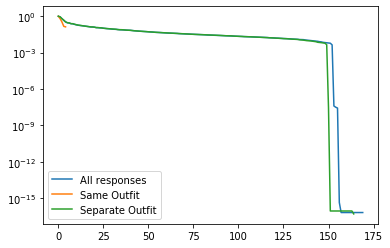

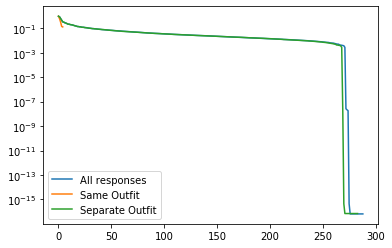

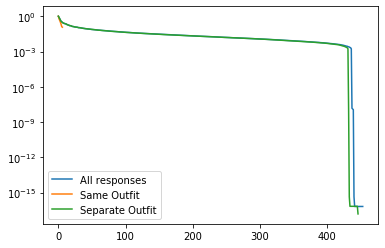

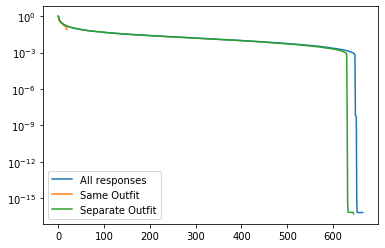

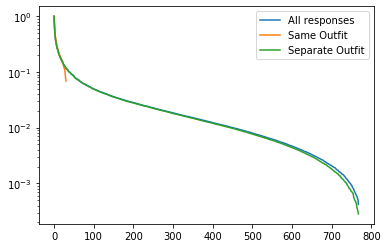

In [10]:
thresh = [0.9, 0.85, 0.8, 0.75, 0.7]
for t in thresh:
    plt.figure()
    embed_32W_best, embed_same_32W_best, embed_separate_32W_best = select_results(t)
    for A in [np.transpose(embed_32W_best), np.transpose(embed_same_32W_best), np.transpose(embed_separate_32W_best)]:
        U,S,Vt = np.linalg.svd(A, full_matrices=False)
        S = [S[i]/S[0] for i in range(len(S))]
        plt.semilogy(S)
    plt.legend(["All responses", "Same Outfit", "Separate Outfit"])

# (Approximately) distributive?

In [11]:
temp = [
    np.array(model.encode(["foo", "bar", "foo"+"bar"])),
    np.array(model.encode(["foo", "bar", "foo"+" "+"bar"])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "Here's a short sentence."+"Is BERT distributive?"])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "Here's a short sentence."+" "+"Is BERT distributive?"])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "The fish swims in the pond."])),
    np.array(model.encode(["Here's a short sentence.", "Is BERT distributive?", "This sentence is short. Does BERT uphold the distributive property?"])),
    np.array(model.encode(["I will go to the store this afternoon.", "The tallest building in the world is the Burj Khalifa.", "I will go to the store this afternoon."+"The tallest building in the world is the Burj Khalifa."])),
    np.array(model.encode(["I will go to the store this afternoon.", "The tallest building in the world is the Burj Khalifa.", "I will go to the store this afternoon."+" "+"The tallest building in the world is the Burj Khalifa."]))
]

for t in temp:
    print(np.dot(t[0]+t[1], t[2]) / (np.linalg.norm(t[0]+t[1]) * np.linalg.norm(t[2])))

0.7797814
0.8732522
0.8964534
0.8964534
0.021588128
0.71422464
0.8697224
0.8697224
